In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150


from hyperion.models.photon_arrival_time.pdf import make_exp_exp_exp, make_obj_func, sample_exp_exp_exp, fb5_mle
from hyperion.models.photon_arrival_time.net import PhotonArivalTimePars
from hyperion.propagate import (
    cascadia_ref_index_func,
    initialize_direction_isotropic,
    make_photon_trajectory_fun,
    make_step_function,
    mixed_hg_rayleigh_antares,
    make_photon_sphere_intersection_func,
    sca_len_func_antares,
    wl_mono_400nm_init,
    make_cherenkov_spectral_sampling_func,
    make_loop_until_isec_or_maxtime,
    make_loop_for_n_steps,
    make_fixed_pos_time_initializer,
    collect_hits
)
from hyperion.utils import calc_tres, make_cascadia_abs_len_func
from hyperion.pmt.pmt import make_calc_wl_acceptance_weight
from hyperion.constants import Constants
import pickle
import scipy.optimize
from torch.utils.data import DataLoader
from hyperion.utils import cherenkov_ang_dist, calc_tres, cherenkov_ang_dist_int
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import torch.optim as optim
%matplotlib inline


from jax import numpy as jnp
from jax import value_and_grad, jit
import pandas as pd
from glob import glob

from fit_tres import make_data, fit, wrap_obj_func
import json

from matplotlib import cm
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from sphere.distribution import fb8







In [3]:
def grid(npts):
    return [_.flatten() for _ in np.meshgrid(np.linspace(0, np.pi, npts), np.linspace(0,2*np.pi, npts))]

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)


def plot_fb8(fb8, npts, offset, ax):
    """
    Plot fb8 on 3D sphere
    """
    xs = fb8.spherical_coordinates_to_nu(*grid(npts))
    pdfs = fb8.pdf(xs)
    z,x,y = xs.T #!!! Note the ordering for xs here is used consistently throughout. Follows Kent's 1982 paper.
    z += offset[2]
    x += offset[0]
    y += offset[1]

    surf = ax.plot_surface(x.reshape(npts, npts),
                    y.reshape(npts, npts),
                    z.reshape(npts, npts),
                    alpha=0.5,
                    rstride=1, cstride=1,
                    facecolors=cm.plasma(pdfs.reshape(npts, npts)/pdfs.max()))
    #ax.set_axis_off()

    return ax, surf

def sph_to_cart(theta, phi=0, r=1):
    """Transform spherical to cartesian coordinates."""
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    return np.array([x, y, z])



# Evaluate Simulations

In [16]:
wl_acc = make_calc_wl_acceptance_weight("data/DOMEfficiency.dat")
det_ph = pickle.load(open("data/photon_table_0.pickle", "rb"))[0]


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


[]

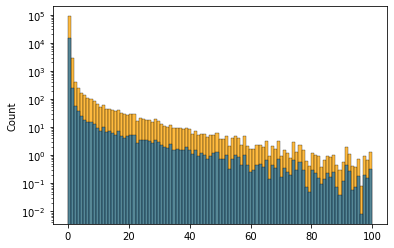

In [17]:
c_medium_f = lambda wl: Constants.BaseConstants.c_vac / cascadia_ref_index_func(wl)

abs_len = make_cascadia_abs_len_func(sca_len_func_antares)
prop_dist = det_ph["times_det"] * c_medium_f(det_ph["wavelengths"])/1E9 
abs_weight = np.exp(-prop_dist / abs_len(det_ph["wavelengths"]))
wl_weight = wl_acc(det_ph["wavelengths"], 0.28)

total_weight = abs_weight * wl_weight

tres = calc_tres(det_ph["times_det"], 0.21, det_ph["dist"], c_medium_f(700)/1E9)
sns.histplot(x=tres, bins = np.linspace(0, 100, 100), weights=abs_weight, color="orange")
sns.histplot(x=tres, bins = np.linspace(0, 100, 100), weights=total_weight)

plt.semilogy()

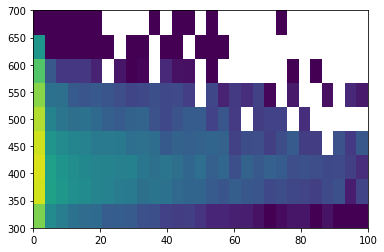

In [18]:
tbins = np.linspace(0, 100, 30)
wl_bins = np.linspace(300, 700, 10)
import matplotlib.colors as colors
h2d = np.histogram2d(tres, det_ph["wavelengths"], bins=(tbins, wl_bins), weights=total_weight)
plt.pcolormesh(tbins, wl_bins, h2d[0].T,
              norm=colors.LogNorm(vmin=1E-2, vmax=1E4))

# Evaluate fitted distributons

In [32]:
fit_pars = pickle.load(open("data/photon_fitpars_0.pickle", "rb"))
det_ph = pickle.load(open("data/photon_table_0.pickle", "rb"))
det_r = 0.21
data = []
for d in fit_pars:
    data.append(list(d["input"]) + list(d["output_tres"])+ list(d["output_arrv_pos"]))
data = np.asarray(np.vstack(data).squeeze(), dtype=np.float32)
data[:, [2, 3, 4]] = np.sort(data[:, [2, 3, 4]], axis=1)
df = pd.DataFrame(data, columns=["obs_theta", "r", "scale1", "scale2", "scale3", "w1", "w2", "mu", "n_photons", "theta", "phi", "psi", "kappa", "beta"])
df["log10_n_photons"] = np.log10(df["n_photons"])
sim_data = det_ph[0]

det_dist = sim_data["dist"]
isec_times = sim_data["times_det"]
ph_thetas = sim_data["emission_angles"]
stepss = sim_data["photon_steps"]
isec_poss = sim_data["positions_det"]
nphotons_sim = sim_data["nphotons_sim"] 
wavelengths = sim_data["wavelengths"]


det_center = np.asarray([0, 0, det_dist])
rel = (isec_poss - det_center)
rel = rel / np.linalg.norm(rel, axis=1)[:, np.newaxis] * det_r




## Simulation Sketch

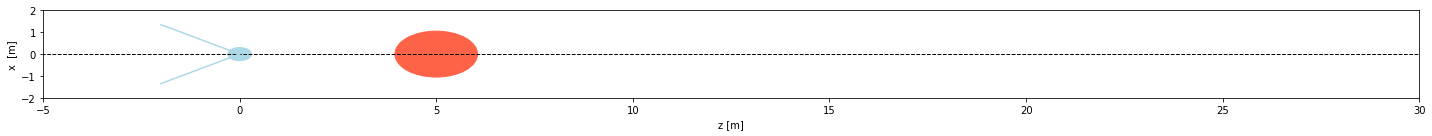

In [21]:
fig, axs = plt.subplots(figsize=(20, 2))
axs.plot([-100, 100], [0, 0], "k--", lw=1)



ang = np.arccos(1/cascadia_ref_index_func(400))
triang_ang = np.pi/2 - ang
triang_len = 2


#poly = mpl.patches.Polygon([[0, 0], [-triang_len, np.sin(ang)*triang_len], [-triang_len, -np.sin(ang)*triang_len]], fill=False, color="lightblue", lw=2)
#axs.add_patch(poly)


circ = mpl.patches.Circle([0, 0], radius=0.3, color="lightblue")
axs.add_patch(circ)

plt.plot([0, -triang_len], [0, np.sin(ang)*triang_len], color="lightblue", ls="-", marker="None")
plt.plot([0, -triang_len], [0, -np.sin(ang)*triang_len], color="lightblue", ls="-", marker="None")

circ = mpl.patches.Circle([det_dist, 0], radius=0.21*5, color="tomato")
axs.add_patch(circ)
axs.set_ylim(-2, 2)
axs.set_xlim(-5, 30)
axs.set_xlabel("z [m]")
axs.set_ylabel("x  [m]")
plt.tight_layout()
plt.savefig("figures/sim_sketch.png", dpi=300)


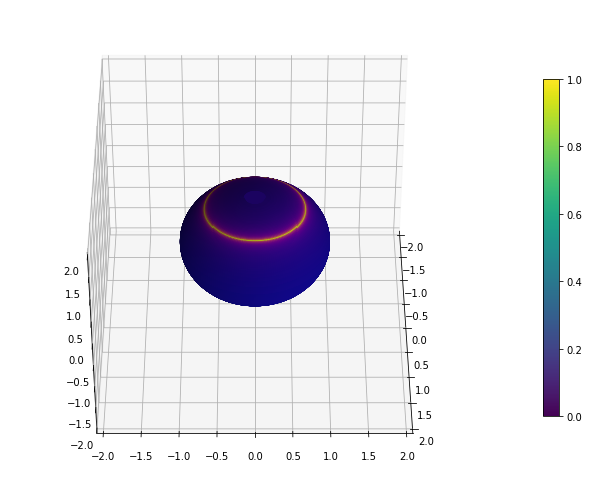

In [22]:
thetas = np.arccos(np.linspace(-1, 1, 200))
phis = np.linspace(0, 2*np.pi, 200)

T, P = np.meshgrid(thetas, phis)
pdf_val = cherenkov_ang_dist(np.cos(T))

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111, projection='3d')
x = np.cos(P)*np.sin(T)
y = np.sin(P)*np.sin(T)
z = np.cos(T)


surf = ax.plot_surface(x, y, z, color="k", alpha=1, 
                facecolors=cm.plasma(pdf_val / pdf_val.max()),
               rstride=1, cstride=1,)

#ax.plot([0, 0], [0, 0], [0, 2], "k-")
ax.set_ylim(-2, 2)
ax.set_xlim(-2, 2)
ax.set_zlim(-2, 2)
ax.view_init(elev=40., azim=0)
fig.colorbar(surf, ax=ax, shrink=0.7)
plt.tight_layout()
plt.savefig("figures/cherenkov_emission_sketch.png", dpi=300)

## Plot angular distribution of photon hits

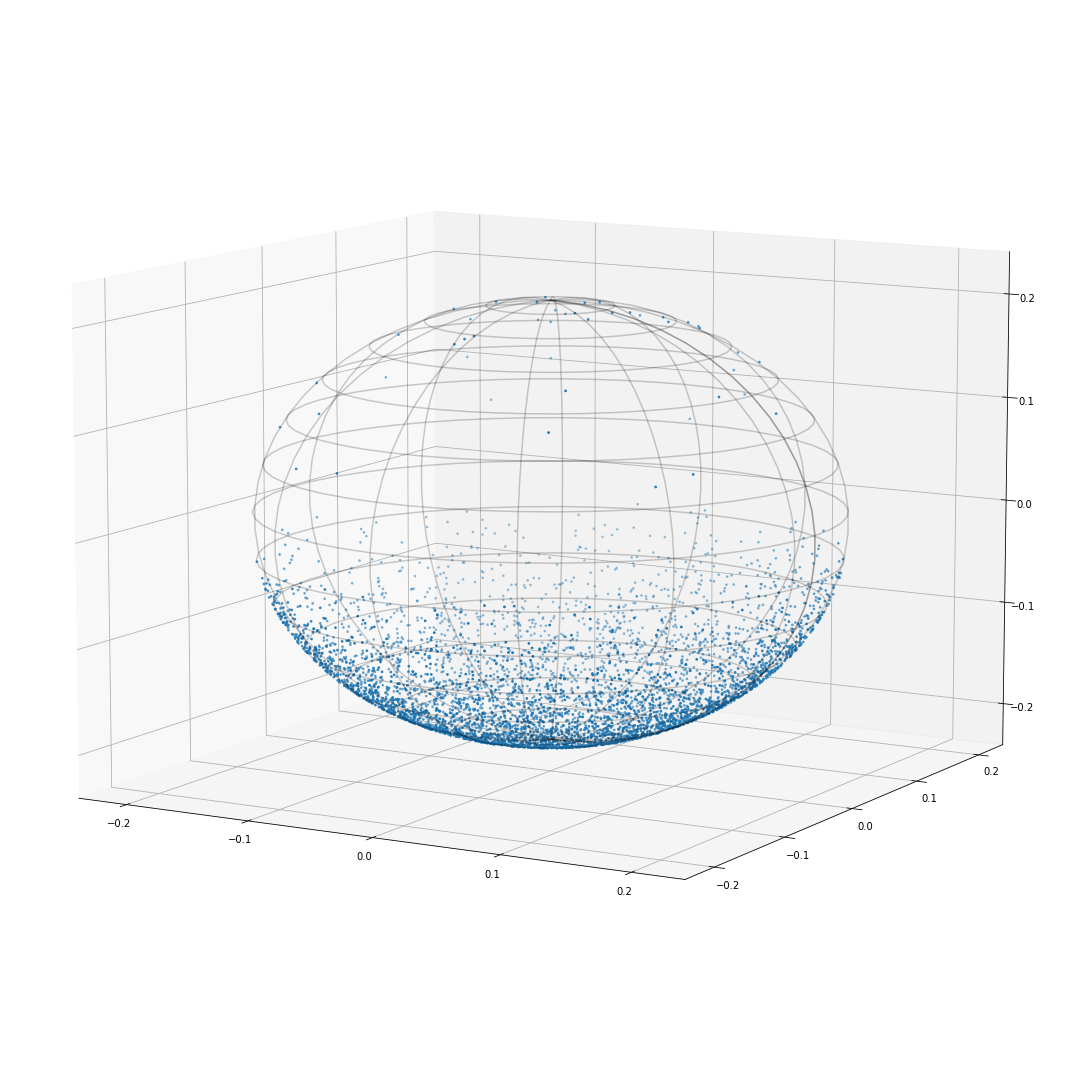

In [23]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:30j]
x = det_r*np.cos(u)*np.sin(v)
y = det_r*np.sin(u)*np.sin(v)
z = det_r*np.cos(v)
#ax.plot_surface(x, y, z, color="k", alpha=0.1)
ax.plot_wireframe(x, y, z, color="k", alpha=0.2, rcount=15, ccount=15)
ax.scatter(rel[:5000, 0], rel[:5000, 1], rel[:5000, 2], s=3)
ax.view_init(elev=10.)
#ax.plot(0, 0, -det_dist, "ok")
#ax.set_xlim(-10, 10)
#ax.set_ylim(-10, 10)
plt.tight_layout()
plt.savefig("figures/photon_arrival_pos_example.png", dpi=250)


## Plot fitted Kent distribution

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

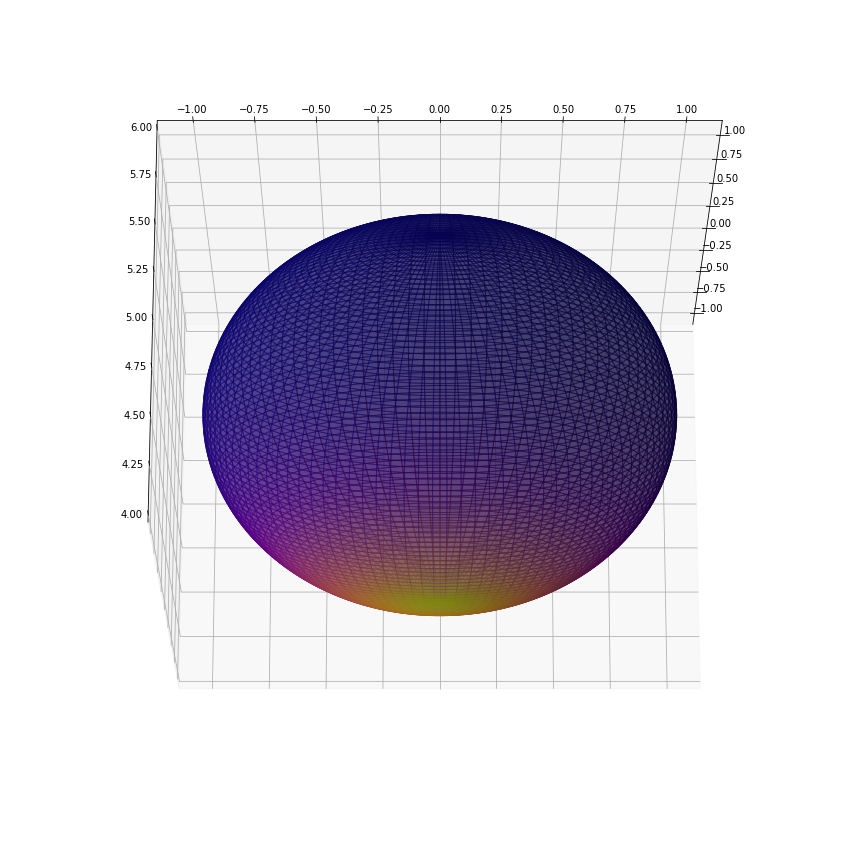

In [24]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(elev=-20., azim=0)
fb_pars = fit_pars[0]["output_arrv_pos"]
fb_dist = fb8(fb_pars[0], fb_pars[1], fb_pars[2], fb_pars[3], max(0, fb_pars[4]), 1.00, 0.00, 0.00)
ax = plot_fb8(fb_dist, 100, np.asarray([0, 0, det_dist]), ax)
#ax.set_title(f"Viewing angle: {np.degrees(fp['input'][0]): .2f}")
plt.tight_layout()
plt.savefig("figures/photon_arrival_pos_example_fit.png", dpi=250)


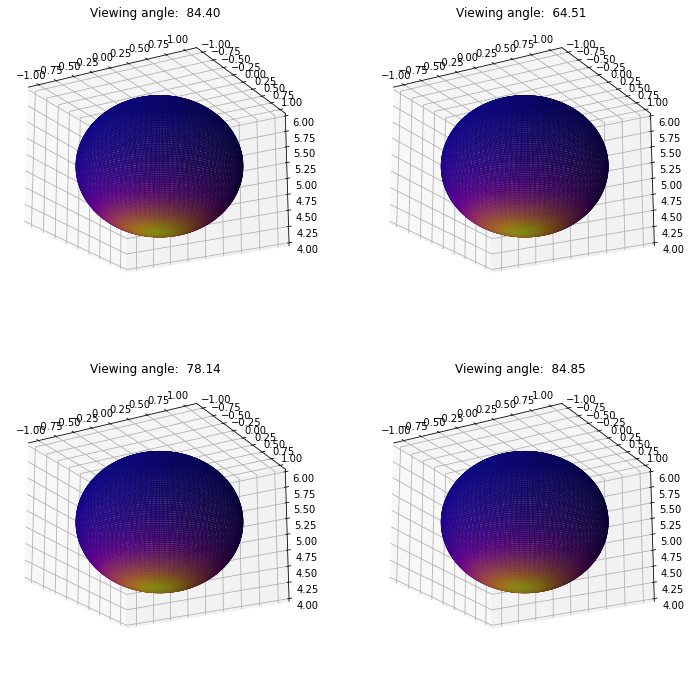

In [26]:
fig = plt.figure(figsize=(12, 12))
for i, fp in enumerate(fit_pars[:4]):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.view_init(elev=-20.)
    fb_pars = fp["output_arrv_pos"]
    fb_dist = fb8(fb_pars[0], fb_pars[1], fb_pars[2], fb_pars[3], max(0, fb_pars[4]), 1.00, 0.00, 0.00)
    ax, _ = plot_fb8(fb_dist, 100, np.asarray([0, 0, det_dist]), ax)
    ax.set_title(f"Viewing angle: {np.degrees(fp['input'][0]): .2f}")

## Plot fit params as function of theta


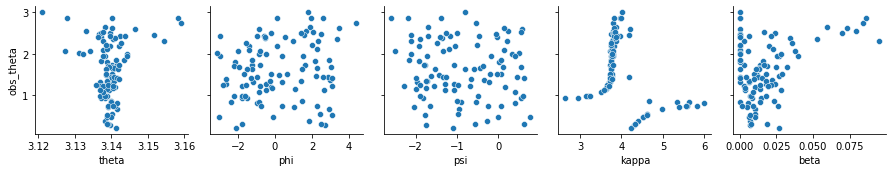

In [27]:
sns.pairplot(df, y_vars =["obs_theta"], x_vars = ["theta", "phi", "psi", "kappa", "beta"])
plt.tight_layout()
plt.savefig("figures/arrival_pos_fit_pars.png", dpi=250)

In [29]:
df.describe()

,obs_theta,r,scale1,scale2,scale3,w1,w2,mu,n_photons,theta,phi,psi,kappa,beta,log10_n_photons
count,103.000000,103.0,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,1.030000e+02,103.000000,103.000000,103.000000,103.000000,1.030000e+02,103.000000
mean,1.609672,1.0,0.043416,0.153375,0.579004,1.248819,0.806700,0.975764,3.475851e+07,3.139578,0.206593,-0.871104,3.944697,1.692029e-02,7.039961
std,0.695343,0.0,0.011469,0.032329,0.058423,0.026389,0.061770,0.020443,6.134643e+07,0.004697,1.909375,0.904341,0.555087,2.006648e-02,0.665588
min,0.216069,1.0,0.025056,0.105920,0.474050,1.193635,0.687198,0.942600,1.129357e+06,3.121092,-3.151315,-2.592725,2.649125,-7.793651e-28,6.052831
25%,1.145163,1.0,0.033370,0.124717,0.526499,1.235811,0.771852,0.954362,2.700754e+06,3.138315,-1.336505,-1.707829,3.730388,3.377758e-03,6.431483
50%,1.527086,1.0,0.040745,0.150152,0.577092,1.250616,0.803901,0.983293,1.085224e+07,3.139478,-0.214004,-0.983903,3.766730,1.124925e-02,7.035520
75%,2.190436,1.0,0.053816,0.176063,0.624111,1.263954,0.844908,0.995495,3.263573e+07,3.140676,1.971424,-0.027701,3.886691,2.267713e-02,7.513693
max,3.004438,1.0,0.063357,0.224735,0.704465,1.308950,0.938121,0.999502,2.753653e+08,3.159177,4.369282,0.772300,5.998809,9.475610e-02,8.439909


## Rotate arrival distribution

[1.99133066 1.15026199] [4.24874137 5.17603659]
(2, 3)


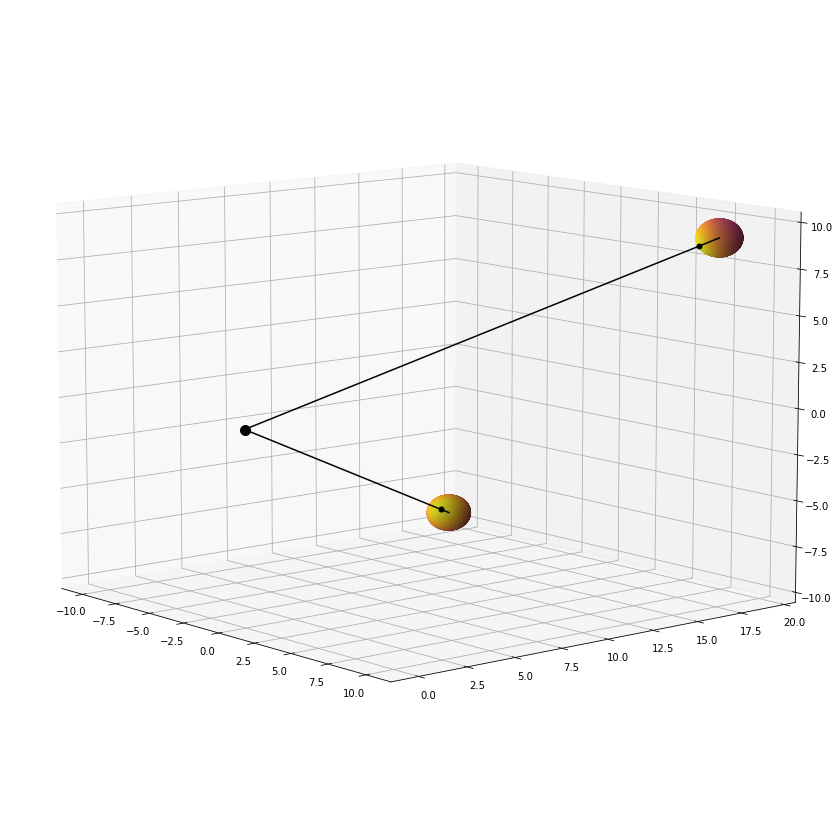

In [12]:
c_medium = 0.299792458 / medium["n_ph"]
inp_data = rel.copy()
inp_data[:,[2, 0]] = inp_data[:,[0, 2]]
weights = np.exp(-isec_times *c_medium / medium["abs_len"])

# Set two module positions that are both det_dist away, but offset from cascade axis
module_coords = np.asarray([[10., 20, 10], [-10, 20., -10]])
module_coords /= np.linalg.norm(module_coords, axis=1)[:, np.newaxis]
module_coords *= det_dist

pdir = np.asarray([0, 0, 1])

#Calculate viewing angle
vtheta = np.arccos(np.dot(module_coords[0], pdir)/ np.linalg.norm(module_coords[0]))
vtheta2 = np.arccos(np.dot(module_coords[1], pdir)/ np.linalg.norm(module_coords[1]))

c_weight = cherenkov_ang_dist(np.cos(ph_thetas-vtheta)) / ANG_DIST_INT *2
dist = fb5_mle(inp_data[:10000], (weights*c_weight)[:10000])

c_weight = cherenkov_ang_dist(np.cos(ph_thetas-vtheta2)) / ANG_DIST_INT *2
dist2 = fb5_mle(inp_data[:10000], (weights*c_weight)[:10000])


rel_theta = np.arccos(module_coords[:, 2] / det_dist) 
rel_phi = np.arccos(module_coords[:, 0] / det_dist / np.sin(rel_theta))

rel_theta = np.pi - rel_theta
rel_phi =  np.pi + rel_phi

print(rel_theta, rel_phi)

rel_xyz = np.asarray([np.sin(rel_theta) * np.cos(rel_phi), np.sin(rel_theta) * np.sin(rel_phi),  np.cos(rel_theta)]).T
print(rel_xyz.shape)  
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=10., azim=-40)


dtest = fb8(rel_theta[0], rel_phi[0], 0, dist[3], dist[4], 1.00, 0.00, 0.00)
ax = plot_fb8(dtest, 100, module_coords[0], ax)

dtest = fb8(rel_theta[1], rel_phi[1], 0, dist[3], dist[4], 1.00, 0.00, 0.00)
ax = plot_fb8(dtest, 100, module_coords[1], ax)


ax.plot([0, module_coords[0, 0]], [0, module_coords[0, 1]], [0, module_coords[0, 2]], "k-", zorder=100)
ax.plot([0, module_coords[1, 0]], [0, module_coords[1, 1]], [0, module_coords[1, 2]], "k-", zorder=100)


ax.plot(0, 0, 0, marker="o", ms=10, color="k", zorder=100)

cent = module_coords + rel_xyz

ax.plot(cent[0, 0], cent[0, 1], cent[0, 2], "ok", ms=5, zorder=100)
ax.plot(cent[1, 0], cent[1, 1], cent[1, 2], "ok", ms=5, zorder=100)
#ax.set_xlim(-10, 0)
#ax.set_ylim(0, 20)
plt.savefig("phot_arriv_dist_teaser.png", dpi=200)
#ax.plot(*sph_to_cart(theta_target, phi_target), marker="o", ms=5, color="k", zorder=100)

#ax.plot(*sph_to_cart(theta_target, phi_target), marker="o", ms=5, color="k", zorder=100)

## Plot time-residual PDF

In [35]:
fit_pars[-2]

{'input': [0.7366240020191286, 1.0],
 'output_tres': [0.513639989166591,
  0.033835816650598344,
  0.12110320395986728,
  1.2051466561191586,
  0.9190992581978628,
  0.9987964074825868,
  106528300.0],
 'output_arrv_pos': array([ 3.13897189,  0.40438113, -0.24535344,  5.55236035,  0.00916051])}

In [ ]:
def calc_c_weight(ph_thetas, obs_angle, wl):
    return  (cherenkov_ang_dist(
                    np.cos(ph_thetas - obs_angle), n_ph=cascadia_ref_index_func(wl)
                )
                / cherenkov_ang_dist_int(cascadia_ref_index_func(wl), -1, 1)
                * 2)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


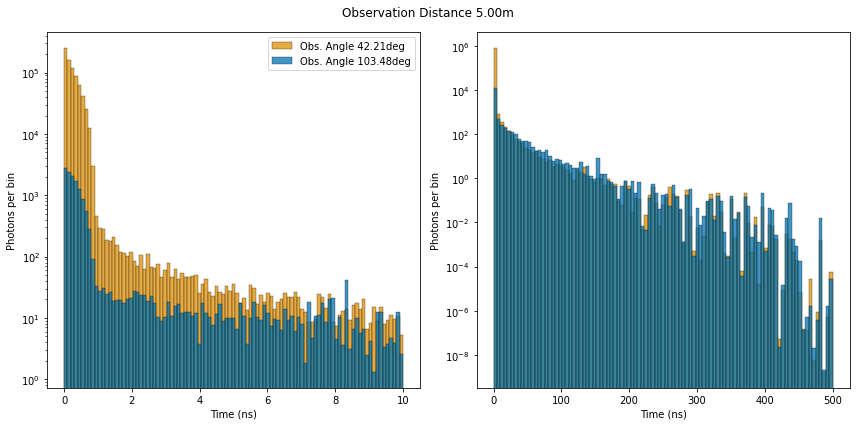

In [38]:
fp0 = fit_pars[9]
fp1 = fit_pars[-2]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

prop_dist = isec_times * c_medium_f(wavelengths)/1E9 
abs_weight = np.exp(-prop_dist / abs_len(wavelengths))
wl_weight = wl_acc(wavelengths, 0.28)
#total_weight = abs_weight * wl_weight
tres = calc_tres(isec_times, 0.21, det_dist, c_medium_f(wavelengths)/1E9 )

colors = sns.color_palette("colorblind")

c_weight = calc_c_weight(ph_thetas, fp1['input'][0], wavelengths)

tot_weight = abs_weight * c_weight

sns.histplot(x=tres, weights=tot_weight, bins=np.linspace(0, 10, 100), stat="count", ax=axs[0], color=colors[1],
             label=f"Obs. Angle {np.degrees(fp1['input'][0]):.2f}deg")
sns.histplot(x=tres, weights=tot_weight, bins=np.linspace(0, 500, 100), stat="count", ax=axs[1], color=colors[1])

c_weight = calc_c_weight(ph_thetas, fp0['input'][0], wavelengths)
tot_weight = abs_weight * c_weight

sns.histplot(x=tres, weights=tot_weight, bins=np.linspace(0, 10, 100), stat="count", ax=axs[0], color=colors[0], 
             label=f"Obs. Angle {np.degrees(fp0['input'][0]):.2f}deg")
sns.histplot(x=tres, weights=tot_weight, bins=np.linspace(0, 500, 100), stat="count", ax=axs[1], color=colors[0])

axs[0].legend()
axs[0].set_yscale("log")
axs[1].set_yscale("log")


axs[0].set_xlabel("Time (ns)")
axs[1].set_xlabel("Time (ns)")
axs[0].set_ylabel("Photons per bin")
axs[1].set_ylabel("Photons per bin")
fig.suptitle(f"Observation Distance {det_dist:.2f}m")
plt.tight_layout()
plt.savefig("figures/time_residual_pdf.png", dpi=250)
#plt.savefig("tres_zoom.png", dpi=300)

## Plot fitted arrival time model

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


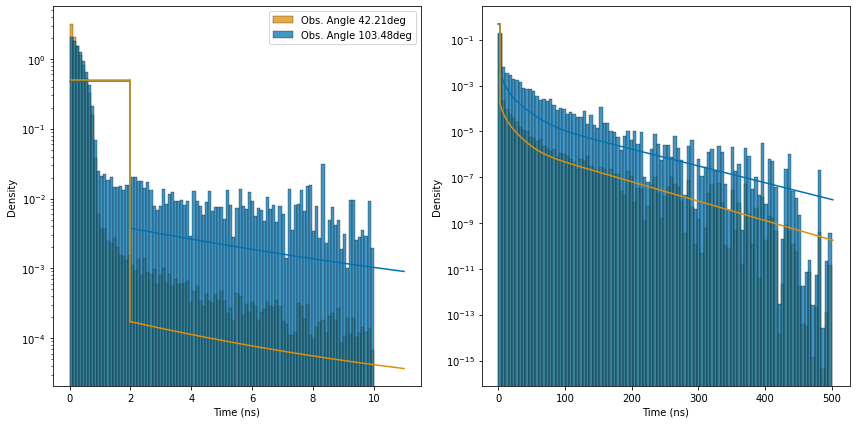

In [41]:
tfig, axs = plt.subplots(1, 2, figsize=(12, 6))

prop_dist = isec_times * c_medium_f(wavelengths)/1E9 
abs_weight = np.exp(-prop_dist / abs_len(wavelengths))
wl_weight = wl_acc(wavelengths, 0.28)
#total_weight = abs_weight * wl_weight
tres = calc_tres(isec_times, 0.21, det_dist, c_medium_f(wavelengths)/1E9 )

colors = sns.color_palette("colorblind")

c_weight = calc_c_weight(ph_thetas, fp1['input'][0], wavelengths)

tot_weight = abs_weight * c_weight

tbins_short = np.linspace(0, 10, 100)
tbins_long = np.linspace(0, 500, 100)

sns.histplot(x=tres, weights=tot_weight, bins=tbins_short, stat="density", ax=axs[0], color=colors[1],
             label=f"Obs. Angle {np.degrees(fp1['input'][0]):.2f}deg")
sns.histplot(x=tres, weights=tot_weight, bins=tbins_long, stat="density", ax=axs[1], color=colors[1])

c_weight = calc_c_weight(ph_thetas, fp0['input'][0], wavelengths)
tot_weight = abs_weight * c_weight

sns.histplot(x=tres, weights=tot_weight, bins=tbins_short, stat="density", ax=axs[0], color=colors[0], 
             label=f"Obs. Angle {np.degrees(fp0['input'][0]):.2f}deg")
sns.histplot(x=tres, weights=tot_weight, bins=tbins_long, stat="density", ax=axs[1], color=colors[0])



model = make_exp_exp_exp()
dx = np.diff(tbins_short)[0]
xs = np.linspace(1E-4, 9, 500)

uni_width = 2

pars = fp0["output_tres"]
axs[0].plot(xs+uni_width, (1-pars[5])*np.exp(model(xs, *pars[:-2])), color=colors[0])
axs[0].plot([0, uni_width], [pars[5]/uni_width, pars[5]/uni_width], color=colors[0])
axs[0].plot([uni_width, uni_width], [pars[5]/uni_width, (1-pars[5])*np.exp(model(0, *pars[:-2]))], color=colors[0])

pars = fp1["output_tres"]
axs[0].plot(xs+uni_width, (1-pars[5])*np.exp(model(xs, *pars[:-2])), color=colors[1])
axs[0].plot([0, uni_width], [pars[5]/uni_width, pars[5]/uni_width], color=colors[1])
axs[0].plot([uni_width, uni_width], [pars[5]/uni_width, (1-pars[5])*np.exp(model(0, *pars[:-2]))], color=colors[1])

dx = np.diff(tbins_long)[0]
xs = np.linspace(1E-4, 500, 500)

pars = fp0["output_tres"]
axs[1].plot(xs+2, (1-pars[5])*np.exp(model(xs, *pars[:-2])), color=colors[0])
axs[1].plot([0, uni_width], [pars[5]/uni_width, pars[5]/uni_width], color=colors[0])
axs[1].plot([uni_width, uni_width], [pars[5]/uni_width, (1-pars[5])*np.exp(model(0, *pars[:-2]))], color=colors[0])

pars = fp1["output_tres"]
axs[1].plot(xs+2, (1-pars[5])*np.exp(model(xs, *pars[:-2])), color=colors[1])
axs[1].plot([uni_width, uni_width], [pars[5]/uni_width, pars[5]/uni_width], color=colors[1])
axs[1].plot([uni_width, uni_width], [pars[5]/uni_width, (1-pars[5])*np.exp(model(0, *pars[:-2]))], color=colors[1])

#usf = 1 - 10 ** (-pars[5])
#surv_ratio = 10 ** pars[6] / 300e7


axs[0].legend()
axs[0].set_yscale("log")
axs[1].set_yscale("log")


axs[0].set_xlabel("Time (ns)")
axs[1].set_xlabel("Time (ns)")
axs[0].set_ylabel("Density")
axs[1].set_ylabel("Density")
fig.suptitle(f"Observation Distance {det_dist:.2f}m")
plt.tight_layout()
plt.savefig("figures/time_residual_pdf_w_model.png", dpi=250)

## Plot fit params as function of theta

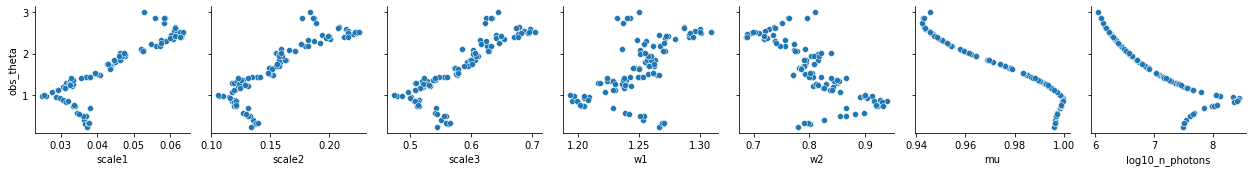

In [42]:
sns.pairplot(df, y_vars =["obs_theta"], x_vars = ["scale1", "scale2", "scale3", "w1", "w2", "mu", "log10_n_photons"])
plt.tight_layout()
plt.savefig("figures/time_residual_pdf_fit_pars.png", dpi=250)

In [35]:
fit_pars[0]

{'input': [1.7375236927648412, 22.360679774997894],
 'output_tres': [0.38991094094240214,
  0.8752757743455982,
  0.04353996947571729,
  0.7220591516543472,
  1.1494221321370728,
  0.668111264705658,
  2.202913069319319e-06],
 'output_arrv_pos': array([ 3.1490497 , -2.95866159,  0.31965757,  2.47045189,  0.        ])}

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


ValueError: too many values to unpack (expected 5)

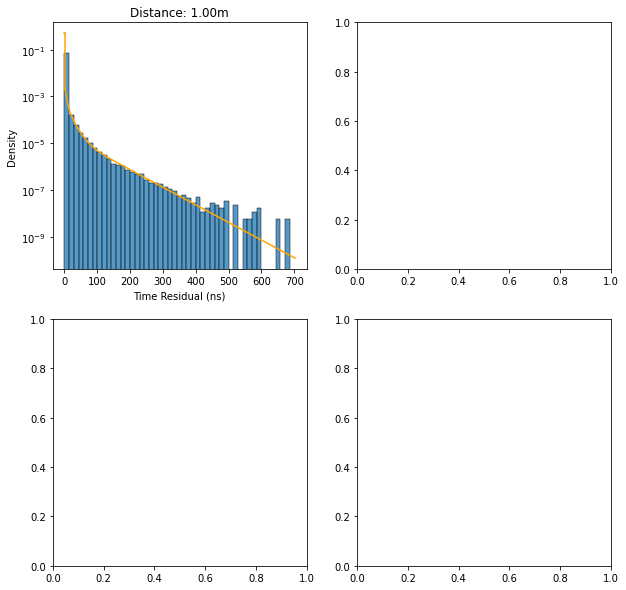

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
uni_width = 2
for i, ax in enumerate(axs.ravel()):
    fit_pars = pickle.load(open(f"data/photon_fitpars_{i}.pickle", "rb"))
    theta = fit_pars[0]["input"][0]
    det_ph = pickle.load(open(f"data/photon_table_{i}.pickle", "rb"))
    det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[0]
    weights = np.exp(-isec_times *c_medium / medium["abs_len"])
    c_weight = cherenkov_ang_dist(np.cos(ph_thetas-theta)) / ANG_DIST_INT *2
    
    total_weight = weights*c_weight
    tres = calc_tres(isec_times, det_r, det_dist, c_medium)
    sns.histplot(x=tres, weights=total_weight, bins=np.linspace(0, 700, 50), stat="density", ax=ax)
    
    model = make_exp_exp_exp()
    xs = np.linspace(0, 700, 700)
    
    pars = fit_pars[0]["output_tres"]
    
    ax.plot(xs+2, (1-pars[5])*np.exp(model(xs, *pars[:-2])), color="orange")
    ax.plot([0, uni_width], [pars[5]/uni_width, pars[5]/uni_width], color="orange")
    ax.plot([uni_width, uni_width], [pars[5]/uni_width, (1-pars[5])*np.exp(model(0, *pars[:-2]))], color="orange")
    
    ax.set_yscale("log")
    ax.set_xlabel("Time Residual (ns)")
    ax.set_title(f"Distance: {det_dist:.2f}m")
plt.tight_layout() 

                       

In [2]:
class MeanStdScaler:
    def __init__(self, data, dont_shift=None, dont_scale=None):
        self._means = np.mean(data, axis=0)
        self._stds = np.std(data, axis=0)
        
        if dont_shift is not None:
            self._means[dont_shift] = 0
            
        if dont_scale is not None:
            self._stds[dont_scale] = 1
        
        
    def scale(self, data):
        return (data - self._means) / self._stds
    
    def unscale(self, data):
        return data * self._stds + self._means

In [14]:
fit_results = pickle.load(open("data/combined_photon_fitpars.pickle", "rb"))
data = []
for d in fit_results:
    data.append(list(d["input"]) + list(d["output_tres"])+ list(d["output_arrv_pos"]))
data = np.asarray(np.vstack(data).squeeze(), dtype=np.float32)
data[:, [2, 3, 4]] = np.sort(data[:, [2, 3, 4]], axis=1)
data[:, 1] = np.log10(data[:, 1])
data[:, 8] = np.log10(data[:, 8])
data[:, 7] = -np.log10(1-data[:, 7])
df = pd.DataFrame(data, columns=["obs_theta", "r", "scale1", "scale2", "scale3", "w1", "w2", "mu", "surv_frac", "theta", "phi", "psi", "kappa", "beta"])

#input_scaler = MeanStdScaler(data[:, :2])
#output_scaler = MeanStdScaler(data[:, 2:], dont_shift=[0, 1, 2, 3, 4, )
#data[:, :2] = input_scaler.scale(data[:, :2])
#data[:, 2:] = output_scaler.scale(data[:, 2:])

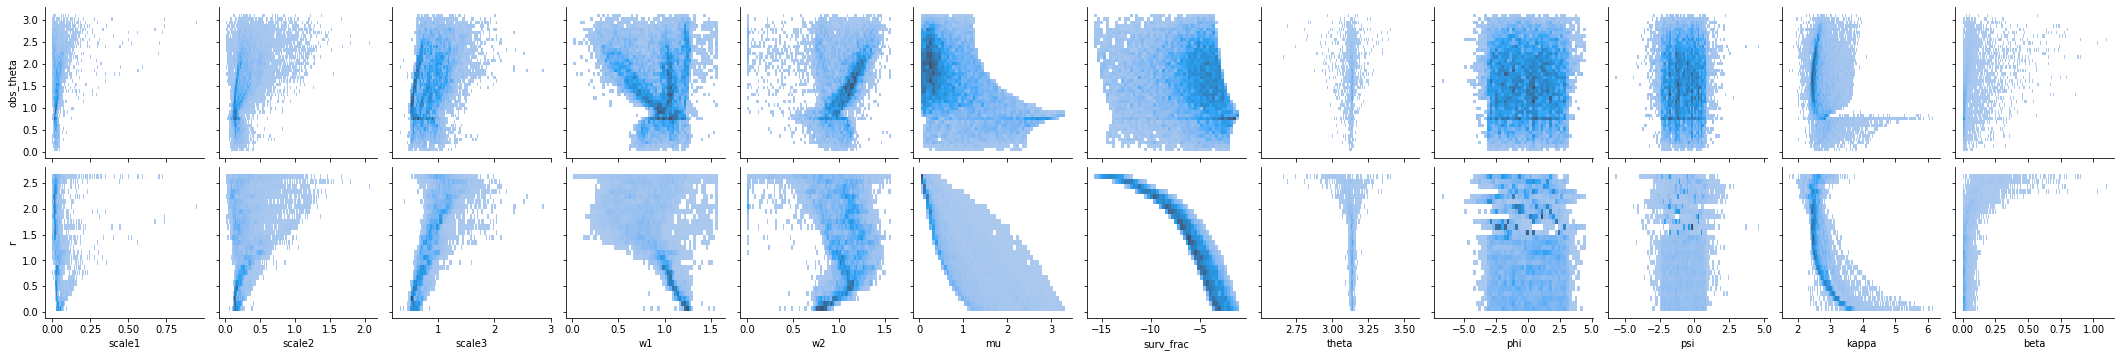

In [15]:
import pandas as pd
sns.pairplot(df,
             kind="hist", y_vars=["obs_theta", "r"], x_vars=["scale1", "scale2", "scale3", "w1", "w2", "mu", "surv_frac", "theta", "phi", "psi", "kappa", "beta"])

<AxesSubplot:xlabel='scale3', ylabel='Count'>

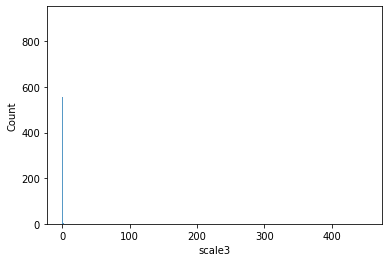

In [30]:
sns.histplot(df["scale3"])

In [33]:
df["scale3"].min()

0.18106821

In [18]:
rstate = np.random.RandomState(0)
indices = np.arange(len(data))
rstate.shuffle(indices)

columns = list(range(9)) + [12, 13]

data_shuff = data[indices][:, columns]

split = int(0.5*len(data))
print(split)

g = torch.Generator()
torch.random.manual_seed(31337)
g.manual_seed(31337)

train_data = torch.tensor(data_shuff[:split])
test_data = torch.tensor(data_shuff[split:])


9715


In [122]:
test_data.shape

torch.Size([9792, 11])

In [9]:
def make_funnel(max_neurons, layer_count):
    layers = []
    out_feat = 7
    previous = max_neurons
    layers.append(max_neurons)
    step_size = int((previous - out_feat) / (layer_count))
    step_size = max(0, step_size)
    for _ in range(layer_count-1):
        previous = previous - step_size
        layers.append(previous)
    return layers

def train_param_net(conf, train_data, test_data, writer=None):
    train_loader = DataLoader(
        train_data,
        batch_size=conf["batch_size"],
        shuffle=True,
        #worker_init_fn=seed_worker,
        generator=g,
    )
    test_loader = DataLoader(
        test_data,
        batch_size=conf["batch_size"],
        shuffle=False,
        #worker_init_fn=seed_worker,
        generator=g,
    )
    
    layers = make_funnel(conf["max_neurons"], conf["layer_count"])
    net = PhotonArivalTimePars(
        layers, conf["n_in"], conf["n_out"], dropout=conf["dropout"],
        final_activations=[F.softplus]*6 + [nn.Identity()] + [F.softplus]*2)
    optimizer = optim.Adam(net.parameters(), lr=conf["lr"])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, conf["epochs"])


    def criterion(pred, target):
        #print(pred.shape, target.shape)
        mse = torch.mean((pred - target)**2, axis=0)
        return mse

    for epoch in range(conf["epochs"]):
        total_train_loss = 0
        for train in train_loader:
            net.train()
            optimizer.zero_grad()
            inp = train[:, :2]
            out = train[:, 2:]
            pred = net(inp)

            loss = criterion(pred, out)
            loss = loss.sum()
            loss.backward()

            total_train_loss += loss.item() * train.shape[0]

            optimizer.step()

        total_train_loss /= train_data.shape[0]

        total_test_loss = 0
        for test in test_loader:
            net.eval()

            inp = test[:, :2]
            out = test[:, 2:]
            pred = net(inp)

            loss = criterion(pred, out)
            loss = loss.sum()


            total_test_loss += loss.item() * test.shape[0]

        total_test_loss /= test_data.shape[0]

        if writer is not None:
            writer.add_scalar("Loss/train", total_train_loss, epoch)
            writer.add_scalar("Loss/test", total_test_loss, epoch)
            writer.add_scalar("LR", optimizer.param_groups[0]["lr"], epoch)

        scheduler.step()

    net.eval()
    inp = test_data[:, :2]
    out = test_data[:, 2:]
    pred = net(inp)
    loss = criterion(pred, out)
    loss = loss.sum()

    hparam_dict = dict(conf)
   

    if writer is not None:
        writer.add_hparams(hparam_dict, {"hparam/accuracy": loss})
        writer.flush()
        writer.close()
    
    return net



        

In [10]:
max_neurons = 700
layer_count = 3
layers = make_funnel(max_neurons, layer_count)
conf = {
        "epochs": 1000,
        "batch_size": 500,
        "lr": 0.01,
        "dropout": 0.5,
        "max_neurons": max_neurons,
        "layer_count": layer_count,
        "n_in": 2,
        "n_out": train_data.shape[1]
    }
writer = SummaryWriter(f"/tmp/tensorboard/runs/{conf['layer_count']}_{conf['max_neurons']}_{conf['batch_size']}_{conf['lr']}_{conf['epochs']}")
net = train_param_net(conf, train_data, test_data, writer)


KeyboardInterrupt: 

In [28]:
!rm -rf /tmp/tensorboard/runs/*

In [32]:
for max_neurons in [700, 1500, 1700]:
    for layer_count in [2, 3, 4, 5]:
        for epochs in [700, 1000]:
            for lr in [0.05, 0.01]:

                conf = {
                    "epochs": epochs,
                    "batch_size": 500,
                    "lr": lr,
                    "dropout": 0.5,
                    "max_neurons": max_neurons,
                    "layer_count": layer_count,
                }

                writer = SummaryWriter(f"/tmp/tensorboard/runs/{conf['layer_count']}_{conf['max_neurons']}_{conf['batch_size']}_{conf['lr']}_{conf['epochs']}")

                net = train_net(conf, train_data, test_data, writer)




KeyboardInterrupt: 

In [10]:
torch.save(net, "data/arival_time_pars_net_w_arriv_pos.dat")

In [16]:
net = torch.load("data/arival_time_pars_net_w_arriv_pos.dat")


In [19]:
net(test_data[:, :2]).detach().shape

torch.Size([9716, 9])

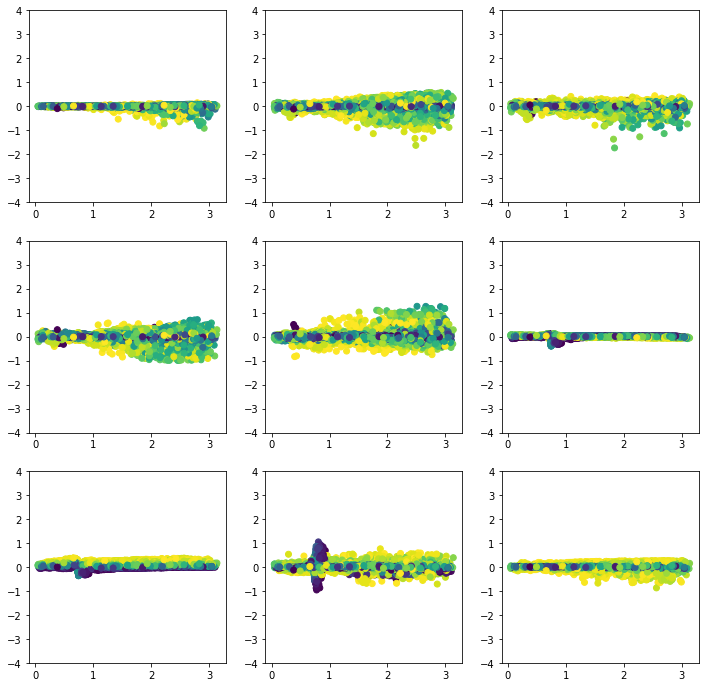

In [20]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i, ax in zip(range(9), axs.ravel()):
    ax.scatter(test_data[:, 0], net(test_data[:, :2]).detach()[:, i]-test_data[:, 2+i].detach(), c=test_data[:, 1])
    ax.set_ylim(-4, 4)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: Fut

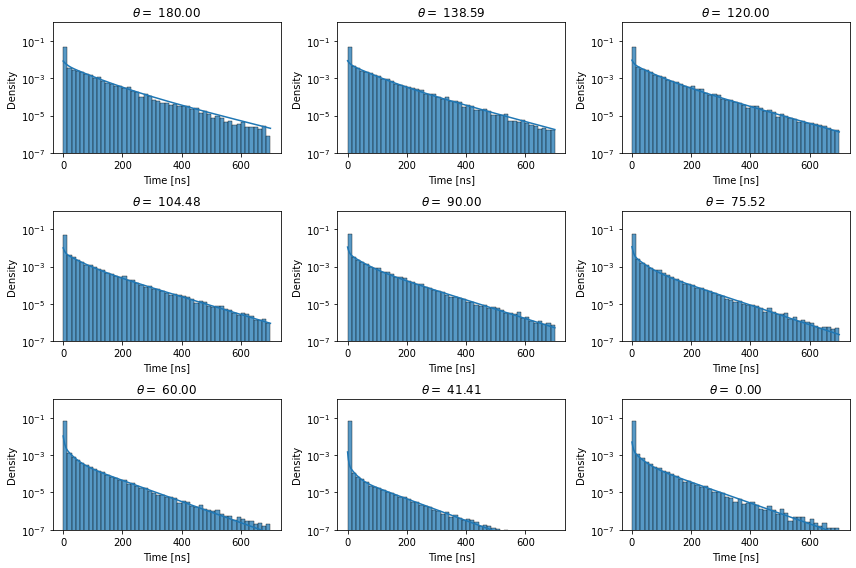

In [37]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8))

thetas = np.arccos(np.linspace(-1, 1, 9))

c_medium = 0.3 / medium["n_ph"]


sim_data = det_ph[0]

det_dist = sim_data["dist"]
isec_times = sim_data["times_det"]
ph_thetas = sim_data["emission_angles"]
stepss = sim_data["photon_steps"]
isec_poss = sim_data["positions_det"]
nphotons_sim = sim_data["nphotons_sim"]

for theta, ax in zip(thetas, axs.ravel()):
    
    weights = np.exp(-isec_times *c_medium / medium["abs_len"])
    c_weight = cherenkov_ang_dist(np.cos(ph_thetas-theta)) / ANG_DIST_INT *2
    t, w, usf = make_data(isec_times, weights*c_weight, det_dist, 0.21, c_medium, thr=1)
    func = make_exp_exp_exp()
    
    scaled_inp = [[theta, np.log10(det_dist)]]
    pars = net(torch.tensor(scaled_inp, dtype=torch.float32))[0].detach()
    pars = np.asarray(pars)
    t, w, _ = make_data(isec_times, weights*c_weight, det_dist, 0.21, c_medium, thr=0)
    sns.histplot(x=t, weights=w, bins=np.linspace(0, 700, 50), stat="density", ax=ax)
    plt.semilogy()

    
    xs = np.linspace(1E-4, 700, 500)
    ax.plot(xs, 10**(-pars[-4])*np.exp(func(xs, *pars[:-4])))

    ax.set_ylim(1E-7, 1)
    ax.set_yscale("log")
    ax.set_title(fr"$\theta =$ {np.degrees(theta):.2f}")
    ax.set_xlabel("Time [ns]")

                 
plt.tight_layout()




/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: Fut

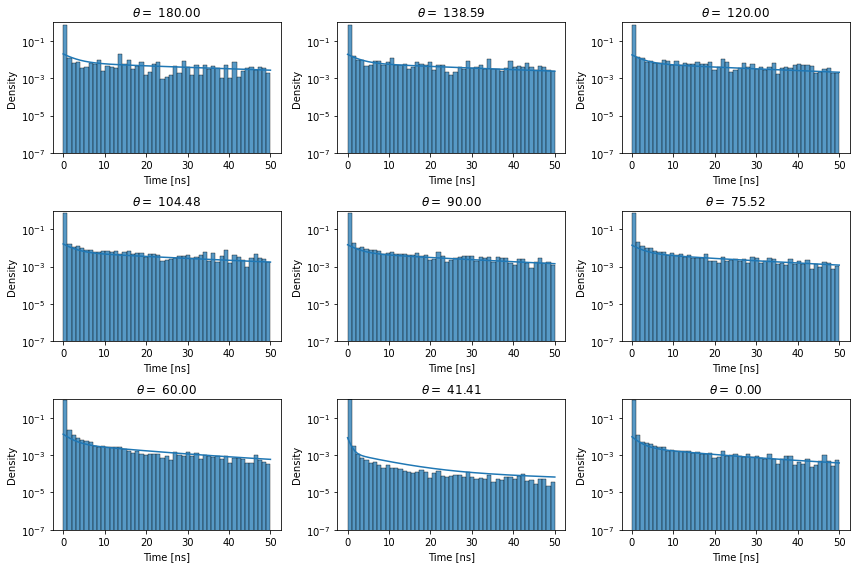

In [90]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8))

thetas = np.arccos(np.linspace(-1, 1, 9))

c_medium = 0.3 / medium["n_ph"]

for theta, ax in zip(thetas, axs.ravel()):
    
    det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[0]
    weights = np.exp(-isec_times *c_medium / medium["abs_len"])
    c_weight = cherenkov_ang_dist(np.cos(ph_thetas-theta)) / ANG_DIST_INT *2
    t, w, usf = make_data(isec_times, weights*c_weight, det_dist, 0.21, c_medium, thr=1)
    func = make_exp_exp_exp()
    
    scaled_inp = [[theta, np.log10(det_dist)]]
    pars = net(torch.tensor(scaled_inp, dtype=torch.float32))[0].detach()
    pars = np.asarray(pars)
    t, w, _ = make_data(isec_times, weights*c_weight, det_dist, 0.21, c_medium, thr=0)
    sns.histplot(x=t, weights=w, bins=np.linspace(0, 50, 50), stat="density", ax=ax)
    plt.semilogy()

    
    xs = np.linspace(1E-4, 50, 500)
    ax.plot(xs, 10**(-pars[-4])*np.exp(func(xs, *pars[:-4])))

    ax.set_ylim(1E-7, 1)
    ax.set_yscale("log")
    ax.set_title(fr"$\theta =$ {np.degrees(theta):.2f}")
    ax.set_xlabel("Time [ns]")

                 
plt.tight_layout()




/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: Fut

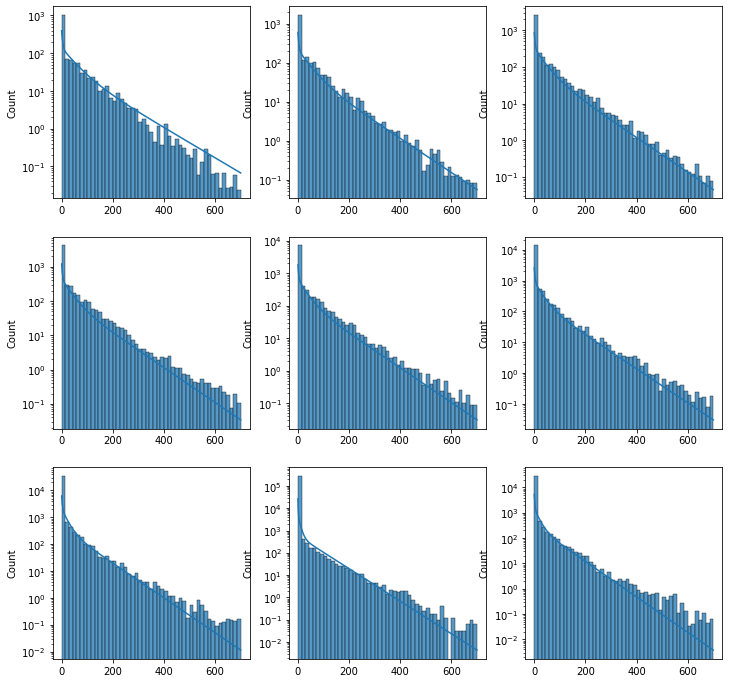

In [38]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

thetas = np.arccos(np.linspace(-1, 1, 9))

tbins = np.linspace(0, 700, 50)
net.eval()
for theta, ax in zip(thetas, axs.ravel()):
    det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[0]
    weights = np.exp(-isec_times *c_medium / medium["abs_len"])
    c_weight = cherenkov_ang_dist(np.cos(ph_thetas-theta)) / ANG_DIST_INT *2
    t, w, usf = make_data(isec_times, weights*c_weight, det_dist, 0.21, c_medium, thr=0)
    func = make_exp_exp_exp()
    
    scaled_inp = [[theta, np.log10(det_dist)]]
    pars = net(torch.tensor(scaled_inp, dtype=torch.float32))[0].detach()
    pars = np.asarray(pars)
    sns.histplot(x=t, weights=w, bins=tbins, stat="count", ax=ax)
    plt.semilogy()

    dx = np.diff(tbins)[0]
    xs = np.linspace(1E-4, 700, 500)
    ax.plot(xs, dx * 10**(pars[-3] - pars[-4])*np.exp(func(xs, *pars[:-4])))

    #ax.set_ylim(1E-3, 1E4)
    ax.set_yscale("log")

                 





In [44]:
def to_three_par(w1, w2):
        three = (
            jnp.array(
                [jnp.sin(w1) * jnp.cos(w2), jnp.sin(w1) * jnp.sin(w2), jnp.cos(w1)]
            )
            ** 2
        )
        return three
    

def sample_timeres(pars, rstate, n_ph_tot):
    
    usf = 1-10**(-pars[5])
    surv_frac = 10**pars[6]
    surv_ph = int(surv_frac*n_ph_tot)
    

    """
    n_ph_tot = np.random.poisson(
        surv_rate * sources[isource].amp * module_efficiencies[idom]
    )
    """
    n_direct, n_indirect = np.random.multinomial(
        surv_ph, [usf, 1 - usf]
    )
    

    
    all_samples = np.empty(surv_ph)

    expon_samples = sample_exp_exp_exp(*pars[:-2], size=n_indirect) + 2

    uni_samples = rstate.uniform(0, 2, size=n_direct)
    
    all_samples[:n_direct] = uni_samples
    all_samples[n_direct:] = expon_samples
    return all_samples
    
    


In [45]:
nphotons_sim

9990000000.0

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: Fut

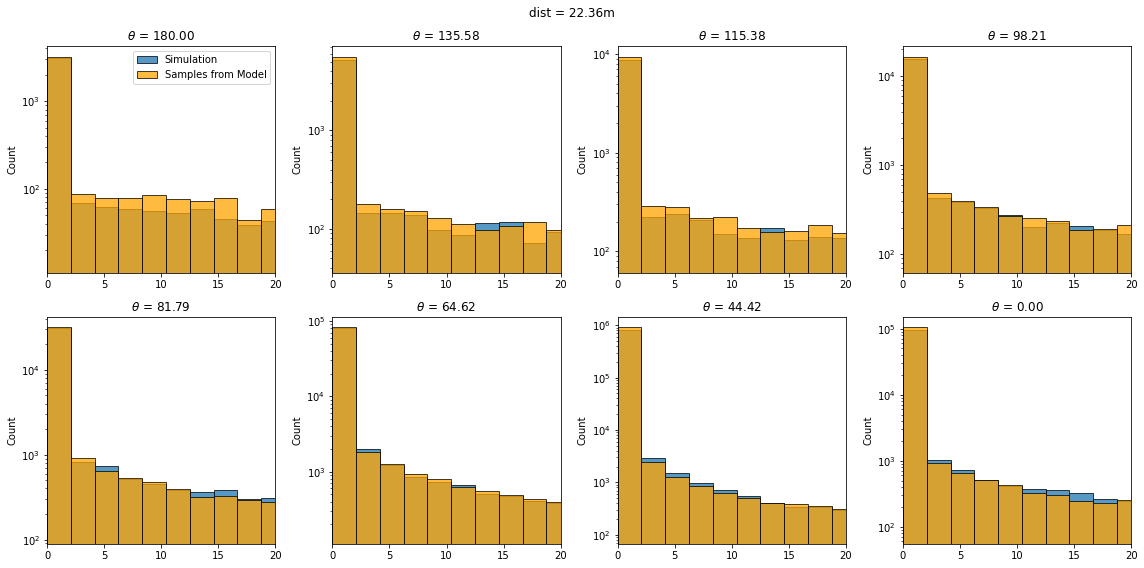

In [46]:
fig, axs = plt.subplots(2, 4, figsize=(4*4, 8))

thetas = np.arccos(np.linspace(-1, 1, 8))

tbins_fine = np.linspace(0, 50, 25)
net.eval()
rstate = np.random.RandomState(0)

sim_data = det_ph[0]

det_dist = sim_data["dist"]
isec_times = sim_data["times_det"]
ph_thetas = sim_data["emission_angles"]
stepss = sim_data["photon_steps"]
isec_poss = sim_data["positions_det"]
nphotons_sim = sim_data["nphotons_sim"]

for theta, ax in zip(thetas, axs.ravel()):

    weights = np.exp(-isec_times *c_medium / medium["abs_len"])
    c_weight = cherenkov_ang_dist(np.cos(ph_thetas-theta)) / ANG_DIST_INT *2
    t, w, usf = make_data(isec_times, weights*c_weight, det_dist, 0.21, c_medium, thr=0)
    func = make_exp_exp_exp()
    
    scaled_inp = [[theta, np.log10(det_dist)]]
    pars = net(torch.tensor(scaled_inp, dtype=torch.float32))[0].detach()
    pars = np.asarray(pars)
    

    samples = sample_timeres(pars[:-2], rstate, nphotons_sim)
    
    sns.histplot(x=t, weights=w, bins=tbins_fine, stat="count", ax=ax, label="Simulation")
    sns.histplot(samples, stat="count", ax=ax, color="orange", bins=tbins_fine, label="Samples from Model")
    
    #dx = np.diff(tbins_fine)[0]
    #xs = np.linspace(1E-4, 700, 500)
    #ax.plot(xs, dx * 10**(pars[-3] - pars[-4])*np.exp(func(xs, *pars[:-4])), color="red", label="Model")

    #ax.set_ylim(1E-3, 1E4)
    ax.set_yscale("log")
    ax.set_title(rf"$\theta$ = {np.degrees(theta):.2f}")
    ax.set_xlim(0, 20)
axs[0][0].legend()
fig.suptitle(f"dist = {det_dist:.2f}m")
plt.tight_layout()
plt.savefig("figures/time_residual_samples_comp_zoom.png", dpi=250)





ValueError: too many values to unpack (expected 5)

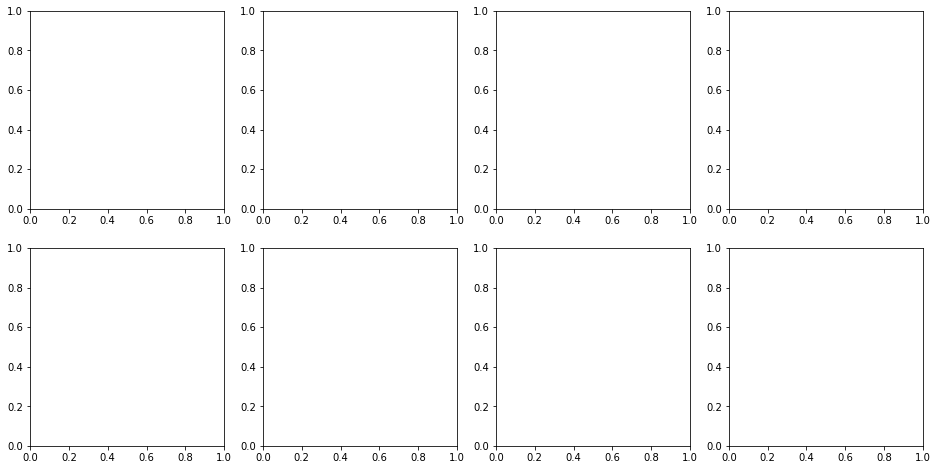

In [47]:
fig, axs = plt.subplots(2, 4, figsize=(4*4, 8))

thetas = np.arccos(np.linspace(-1, 1, 8))

tbins_fine = np.linspace(0, 500, 50)
net.eval()
rstate = np.random.RandomState(0)

for theta, ax in zip(thetas, axs.ravel()):
    det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[0]
    weights = np.exp(-isec_times *c_medium / medium["abs_len"])
    c_weight = cherenkov_ang_dist(np.cos(ph_thetas-theta)) / ANG_DIST_INT *2
    t, w, usf = make_data(isec_times, weights*c_weight, det_dist, 0.21, c_medium, thr=0)
    func = make_exp_exp_exp()
    
    scaled_inp = [[theta, np.log10(det_dist)]]
    pars = net(torch.tensor(scaled_inp, dtype=torch.float32))[0].detach()
    pars = np.asarray(pars)
    

    samples = sample_timeres(pars[:-2], rstate)
    
    sns.histplot(x=t, weights=w, bins=tbins_fine, stat="count", ax=ax, label="Simulation")
    sns.histplot(samples, stat="count", ax=ax, color="orange", bins=tbins_fine, label="Samples from Model")
    
    #dx = np.diff(tbins_fine)[0]
    #xs = np.linspace(1E-4, 700, 500)
    #ax.plot(xs, dx * 10**(pars[-3] - pars[-4])*np.exp(func(xs, *pars[:-4])), color="red", label="Model")

    #ax.set_ylim(1E-3, 1E4)
    ax.set_yscale("log")
    ax.set_title(rf"$\theta$ = {np.degrees(theta):.2f}")
    ax.set_xlim(0, 500)
axs[0][0].legend()
fig.suptitle(f"dist = {det_dist:.2f}m")
plt.tight_layout()
plt.savefig("figures/time_residual_samples_comp.png", dpi=250)





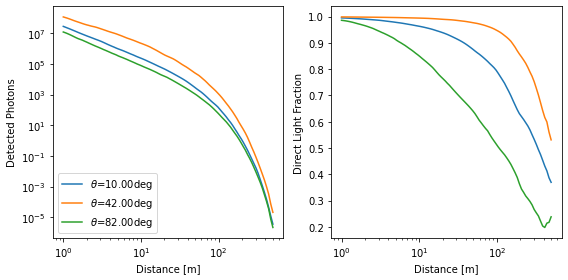

In [97]:
dists = np.logspace(0, np.log10(500), 100)
thetas = np.radians([10, 42, 82])

T, D = torch.meshgrid(torch.tensor(thetas, dtype=torch.float), torch.tensor(np.log10(dists), dtype=torch.float))
inputs = torch.stack([T.ravel(), D.ravel()]).T
pars = net(inputs).detach()
pars = pars.reshape(3, 100, 9)


fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for ix, ax in zip([6, 5], axs):

    
    if ix == 6:
        transf = lambda p: 10**p
    else:
        transf = lambda p: 1- 10**(-p)

        
    ax.plot(dists, transf(pars[0, :, ix]), label=rf"$\theta$={np.degrees(thetas[0]):.2f}deg")
    ax.plot(dists, transf(pars[1, :, ix]), label=rf"$\theta$={np.degrees(thetas[1]):.2f}deg")
    ax.plot(dists, transf(pars[2, :, ix]), label=rf"$\theta$={np.degrees(thetas[2]):.2f}deg")

axs[0].set_xscale("log")
axs[1].set_xscale("log")
axs[0].set_yscale("log")

axs[0].set_xlabel("Distance [m]")
axs[0].set_ylabel("Detected Photons")
axs[1].set_xlabel("Distance [m]")
axs[1].set_ylabel("Direct Light Fraction")
axs[0].legend()
plt.tight_layout()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


(0.0, 50.0)

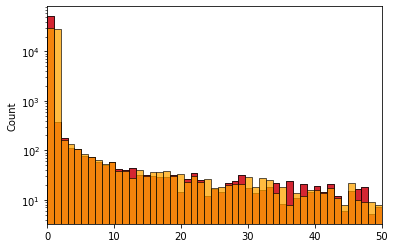

In [17]:
fig, ax = plt.subplots()
rstate = np.random.RandomState(0)
tbins_fine = np.linspace(0, 50, 50)
theta = np.radians(30)
det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[0]
scaled_inp = [[theta, np.log10(det_dist)]]
pars = net(torch.tensor(scaled_inp, dtype=torch.float32))[0].detach()
pars = np.asarray(pars)
samples = sample_timeres(pars[:-2], rstate)

weights = np.exp(-isec_times *c_medium / medium["abs_len"])
c_weight = cherenkov_ang_dist(np.cos(ph_thetas-theta)) / ANG_DIST_INT *2
t, w, usf = make_data(isec_times, weights*c_weight, det_dist, 0.21, c_medium, thr=0)


t_tts = t + rstate.normal(0, 2, size=t.shape[0])


sns.histplot(x=t, weights=w, bins=tbins_fine, stat="count", ax=ax, label="Simulation")
sns.histplot(x=t, weights=w, bins=tbins_fine, stat="count", ax=ax, label="Simulation + TTS", color="red")
sns.histplot(samples, stat="count", ax=ax, color="orange", bins=tbins_fine, label="Samples from Model")
plt.semilogy()
plt.xlim(0, 50)

In [118]:
from numba import float64, jit
from numba.experimental import jitclass
import numpy as np
from hyperion.constants import Constants

import sys
sys.path.append("/app/gnn_testbed/")
from gnn_testbed.event_generation.photon_propagation import PhotonSource
from gnn_testbed.event_generation.detector import Detector, Module, make_line

exp_exp_exp_sampler = jit(sample_exp_exp_exp)

@jit(nopython=True)
def sample_times(pdf_params, sources, module_coords, module_efficiencies):

    all_times_det = []
    for idom in range(module_coords.shape[0]):

        this_times = []
        total_length = 0
        for isource in range(len(sources)):
            pars = pdf_params[isource, idom]
            usf = 1-10**(-pars[5])
            surv_ratio = 10**pars[6] / 300E7
            n_ph_tot = np.random.poisson(
                surv_ratio * sources[isource].amp * module_efficiencies[idom]
            )

            n_direct, n_indirect = np.random.multinomial(
                n_ph_tot, [usf, 1 - usf]
            )


            all_samples = np.empty(n_ph_tot)

            """
            Can't use this with numba yet
            expon_samples = sampler(*pars[:-2], size=n_indirect, rstate=rstate) + 2
            """
            expon_samples = exp_exp_exp_sampler(pars[0], pars[1], pars[2], pars[3], pars[4], n_indirect) + 2
            uni_samples = np.random.uniform(0, 2, size=n_direct)

            all_samples[:n_direct] = uni_samples
            all_samples[n_direct:] = expon_samples

            this_times.append(all_samples)
            total_length += n_ph_tot

        this_times_arr = np.empty(total_length)
        i = 0
        for tt in this_times:
            this_times_arr[i : i + tt.shape[0]] = tt  # noqa: E203
            i += tt.shape[0]

        all_times_det.append(this_times_arr)

    return all_times_det


def make_generate_photons_nn(model_path):
    import torch

    model = torch.load(model_path)
    model.eval()

    def generate_photons_nn(
        module_coords,
        module_efficiencies,
        sources,
        seed=31337,
    ):

        all_times_det = []
        np.random.seed(seed)

        source_pos = np.empty((len(sources), 3))
        source_amp = np.empty(len(sources))
        source_dir = np.empty((len(sources), 3))

        for i in range(len(sources)):
            source_pos[i] = sources[i].pos
            source_amp[i] = sources[i].amp
            source_dir[i] = sources[i].dir

        source_targ_vec = module_coords[np.newaxis, ...] - source_pos[:, np.newaxis, :]
        dist = np.linalg.norm(source_targ_vec, axis=-1)
        angles = np.arccos(
            np.einsum(
                "abk, ak -> ab",
                source_targ_vec,
                source_dir
            )
            / dist
        )
       
        inp_pars = torch.stack([torch.tensor(angles.ravel(), dtype=torch.float), torch.tensor(np.log10(dist.ravel()), dtype=torch.float)], dim=-1)
        
        pdf_params = (
            model(inp_pars).detach()
            .numpy()
        ).reshape([angles.shape[0], angles.shape[1], 7])

        
        all_times_det = sample_times(
            pdf_params, sources, module_coords, module_efficiencies
        )

        return all_times_det

    return generate_photons_nn

In [119]:
modules = make_line(0, 0, 20, 50, np.random.RandomState(0), 1E-6, 0)

In [120]:

det = Detector(modules)
gen_ph = make_generate_photons_nn("data/arival_time_pars_net.dat")

src = PhotonSource(np.asarray([10., 0., 0]), 10E3*5.3 * 250 * 1e2, 0, np.asarray([0, 0, 1.]))
src2 = PhotonSource(np.asarray([15., 0., 0]), 10E3*5.3 * 250 * 1e2, 0, np.asarray([0, 0, 1.]))
all_times_det = gen_ph(det.module_coords, det.module_efficiencies, [src, src2])

/opt/conda/lib/python3.7/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'sources' of function 'sample_times'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../tmp/ipykernel_91/2319152228.py", line 13:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [121]:
all_times_det

[array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([  1.72380042, 141.50025887,   1.29104043,   0.36878554]),
 array([3.13884299e-01, 1.35968180e+00, 6.74534994e-01, 9.76057960e-01,
        1.54222890e+00, 7.85311569e-01, 6.79684673e-01, 6.68812242e-01,
        1.87318437e+00, 2.95677781e-01, 1.55290379e+00, 1.35452496e+00,
        7.70115407e-01, 4.96838897e-01, 1.37180543e+00, 1.13394289e+00,
        1.06350545e+00, 9.63462344e-01, 1.73535635e-01, 1.17561608e+00,
        1.20380374e+00, 5.67103861e-01, 5.10225176e-01, 1.12372445e+00,
        1.80849402e+00, 2.81536094e-01, 5.18129413e-01, 1.11615347e+00,
        7.85028423e-01, 9.04045054e-01, 1.42081003e+00, 9.06174799e-01,
        1.07200976e+00, 7.62092495e-01, 1.78360143e+00, 1.43844211e+00,
        1.66746376e+00, 8.09866187e-01, 1.98947728e+00, 1.83612450e+00

[]

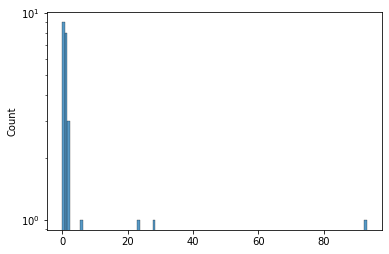

In [5]:
sample_times(a, b, c, d)

/opt/conda/lib/python3.7/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'sources' of function 'sample_times'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../tmp/ipykernel_3580692/1926473208.py", line 13:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


[array([], dtype=float64)]

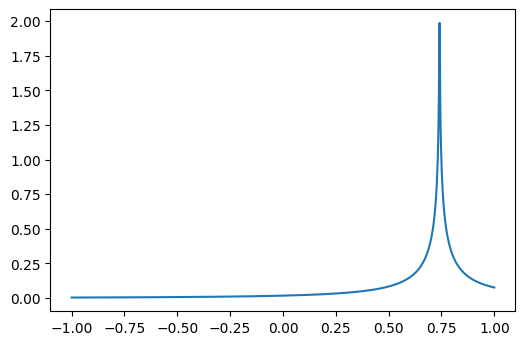

In [2]:
ct = jnp.linspace(-1, 1, 1000)
plt.plot(ct, cherenkov_ang_dist(ct))
a = 4.27033
d = -0.00103
maxval = a - d

In [3]:
fp = np.memmap("photons.dat", dtype="float32", mode="r", shape=(int(1e7), 15, 4))
fpd = np.memmap("photon_dirs.dat", dtype="float32", mode="r", shape=(int(1e7), 3))

In [4]:
theta = np.arccos(1/1.35)
costheta = np.cos(theta)
r = 10

target_x = sph_to_cart(theta, r)
target_r = 0.3

all_t = []
all_w = []

key = random.PRNGKey(0)

nph = int(1E6)
for i in range(10):
    key, subkey = random.split(key)
    isec_times, isec, weights = calc_intersections(fp[nph*i:(i+1)*nph, :, :3], fp[nph*i:(i+1)*nph, :, 3], target_x, target_r, 30, 100 / 90)
    tph = jnp.arccos(fpd[nph*i:(i+1)*nph, 2][jnp.any(isec, axis=1)])
    c_weight = cherenkov_ang_dist(jnp.cos(tph-theta)) / maxval
    all_t.append(isec_times)
    all_w.append(weights*c_weight)
all_t = np.concatenate(all_t)
all_w = np.concatenate(all_w)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:385: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


[]

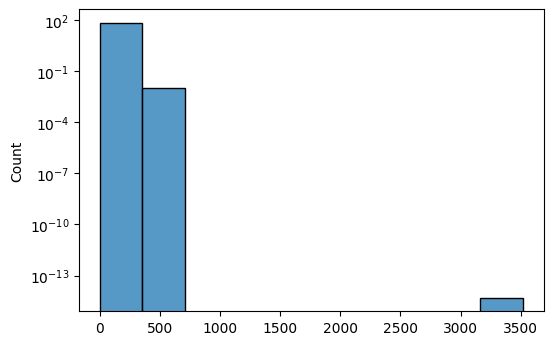

In [5]:
sns.histplot(x=all_t, weights=all_w)
plt.semilogy()

(10, 15)


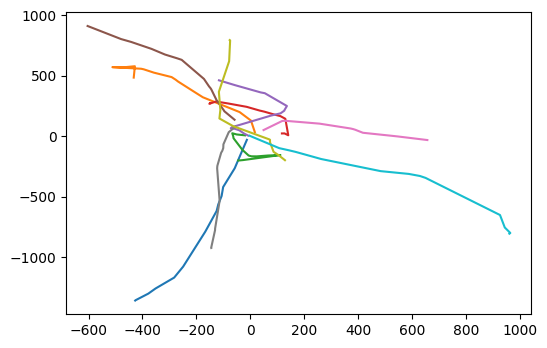

In [55]:
c_medium = 0.3 / 1.35
abs_len = 30
cnt= 10
weights = c_medium * jnp.cumsum(fp[:cnt, :, 3], axis=1) / abs_len 
print(weights.shape)
tph = jnp.arccos(fpd[:cnt, 2])[:, np.newaxis]
weights += jnp.log(cherenkov_ang_dist(jnp.cos(tph-theta)) / maxval)
plt.plot(fp[:cnt, :, 0].T, fp[:cnt, :, 1].T, )#color="k", alpha=0.3);
#plt.scatter(fp[:cnt, :, 0].T, fp[:cnt, :, 1].T, s=10, c=weights)

In [41]:
weights

DeviceArray([[1.56359270e-03, 8.22196063e-03, 2.00255346e-02, ...,
              4.41593230e-01, 5.06838322e-01, 5.72282612e-01],
             [7.41667524e-02, 4.49892193e-01, 9.93589997e-01, ...,
              9.73245049e+00, 1.09010391e+01, 1.21415501e+01],
             [3.92781764e-01, 1.52259445e+00, 2.67169333e+00, ...,
              5.65068169e+01, 6.61603012e+01, 7.60157776e+01],
             ...,
             [3.52552459e-02, 2.08424270e-01, 5.51545143e-01, ...,
              1.09529743e+01, 1.29722805e+01, 1.49930649e+01],
             [1.21581249e-01, 2.84927815e-01, 4.49799180e-01, ...,
              3.47459435e+00, 3.89629364e+00, 4.31951427e+00],
             [8.24529156e-02, 1.89396158e-01, 6.21439517e-01, ...,
              9.45266533e+00, 1.06455526e+01, 1.19224834e+01]],            dtype=float32)

In [94]:
a = np.ones((2, 3))
b = np.ones((5, 3))*2

np.linalg.norm((a[:, np.newaxis, : ] - b[np.newaxis, ...]), axis=(-1)).shape

(2, 5)

In [95]:
np.einsum('abk, ijk -> aj', a[:, np.newaxis, : ], b[np.newaxis, ...])

array([[6., 6., 6., 6., 6.],
       [6., 6., 6., 6., 6.]])

In [83]:
for i in range(a.shape[0]):
    for j in range(b.shape[1]):
        print(np.dot(a[i, j]
    

array([[1., 1., 1.],
       [1., 1., 1.]])

In [84]:
b

array([[2., 2., 2.],
       [2., 2., 2.]])

In [85]:
1 *2 + 1*2 + 1*2

6